In [2]:
library(tidyverse)
options(repr.plot.height=4, repr.plot.width=6)
theme_set(theme_classic())
library(modelr)
install.packages(c("glmnet", "tidymodels", "ranger"))
library(glmnet)
library(tidymodels)
options(repr.plot.height=5, repr.plot.width=8)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Lecture 20: Classification and logistic regression

<div style="border: 1px double black; padding: 10px; margin: 10px">

**After today's lecture you will understand:**
* Fitting logistic regression models in R using `glm()`.
* Use the fitted model to predict outcome for new dataset.
* Ways to measure the accuracy of a binary classifier.
</div>



## Modeling with categorical outcomes
Last lecture we learned all about regression. In regression, we have a continuous outcome (height, population growth, etc.), and some predictors which could be either categorical or continuous. We built a function that predicts the mean of the outcome given the predictors, e.g.

$$
\mathbb{E}(y \mid x) = a_0 + a_1 x.
$$

For example, we fit the following model:

In [4]:
lm(log(price) ~ log(carat), diamonds)


Call:
lm(formula = log(price) ~ log(carat), data = diamonds)

Coefficients:
(Intercept)   log(carat)  
      8.449        1.676  


This says that the average value of `log(price)` given `log(carat)` is 

$$8.449 + 1.676 \cdot \log(\text{carat})\quad\text{(avg. value of log(price))}$$

In today's lecture, we are going to look at a different kind of regression model, with the main difference being that our outcome is no longer a continuous variable like price or log(price). Instead, the outcome is a True/False variable which indicates whether or not some event happened.

## Deaths on the *RMS Titanic*
The [RMS Titanic](https://en.wikipedia.org/wiki/Titanic) famously sank on April 15, 1912 during its maiden voyage, killing about 2/3rds of its passengers. The `titanic` data set records the fates of everyone aboard.

In [5]:
data(Titanic)
titanic_df <- Titanic %>% as_tibble %>% mutate(Survived = Survived == "Yes") 
titanic_df <- titanic_df[rep(row.names(titanic_df), titanic_df$n), -5]
titanic_df %>% head

Class,Sex,Age,Survived
<chr>,<chr>,<chr>,<lgl>
3rd,Male,Child,FALSE
3rd,Male,Child,FALSE
3rd,Male,Child,FALSE
3rd,Male,Child,FALSE
3rd,Male,Child,FALSE
3rd,Male,Child,FALSE


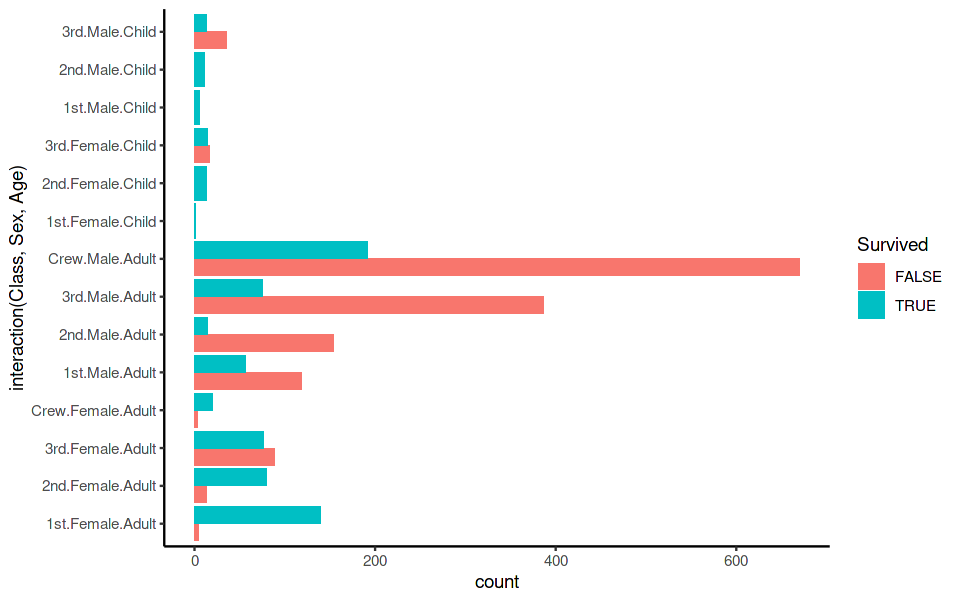

In [ ]:
ggplot(titanic_df) + geom_bar(aes(x=interaction(Class, Sex, Age), fill=Survived), 
                              position='dodge') + coord_flip()

We have three categorical predictors: sex, age (adult / child), and class (1st-3rd or crew). Our outcome is also categorical: survived or not.

## Logistic regression
Suppose we want to build a regression model for predicting categorical outcomes.
In all of the regressions we have seen so far, the dependent ($y$) variable has been continuous: population growth, life expectancy, price, etc. However, there are many situations where the outcome is categorical. For simplicity, we will assume it's binary, and can be coded as 0/1. How should we model binary data?

One idea is to just stick what we know and use the linear model. Will this work?

In [6]:
mdl <- lm(Survived ~ Class + Sex + Age, data = titanic_df)
summary(mdl)


Call:
lm(formula = Survived ~ Class + Sex + Age, data = titanic_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8930 -0.2268 -0.2163  0.2324  0.9044 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.89303    0.02585  34.546  < 2e-16 ***
Class2nd    -0.18608    0.03301  -5.637 1.95e-08 ***
Class3rd    -0.30673    0.02771 -11.070  < 2e-16 ***
ClassCrew   -0.17555    0.02797  -6.277 4.15e-10 ***
SexMale     -0.49068    0.02301 -21.329  < 2e-16 ***
AgeChild     0.18130    0.04097   4.425 1.01e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4047 on 2195 degrees of freedom
Multiple R-squared:  0.2529,	Adjusted R-squared:  0.2512 
F-statistic: 148.6 on 5 and 2195 DF,  p-value: < 2.2e-16


R did not generate any errors. But the regression looks "weird" in many ways:
- The $R$-squared low.
- The residual standard error is large relative to the outcome (which is always either zero or one).
- The residuals look weird:

In [7]:
tu %>% add_residuals(mdl) %>% mutate(resid=as.numeric(resid)) %>% 
    ggplot + geom_histogram(aes(x=resid), binwidth=.1)

ERROR: ignored

What about predictions? The predicted outcomes are decimal numbers, whereas in the original model, the outcome was `TRUE` or `FALSE`.

In [ ]:
titanic_df %>% add_predictions(mdl) %>% distinct %>% head

Class,Sex,Age,Survived,pred
<chr>,<chr>,<chr>,<lgl>,<dbl>
3rd,Male,Child,FALSE,0.2769110
3rd,Female,Child,FALSE,0.7675908
1st,Male,Adult,FALSE,0.4023497
2nd,Male,Adult,FALSE,0.2162696
3rd,Male,Adult,FALSE,0.0956153
Crew,Male,Adult,FALSE,0.2267959


The linear model says:

$$y = f(a + b x)$$ 

for $f(x)=x$. For 0/1 outcomes, let's instead try to think probabilistically:

$$\text{Prob}(y=1) = \underbrace{f(a + b x)}_{(\text{some function of the covariates})}$$

What criteria should this function $f$ have?
- It's range needs to be $[0,1]$.
- For "extreme" values of $a + bx$ it should tend to zero one one.

A function which satisfies both the properties is the **logistic function**:
$$f(x) = \frac{1}{1 + e^{-x}}.$$

![image.png](attachment:image.png)

In [ ]:
# expand.grid(x=seq(-5, 5, .1)) %>% ggplot(aes(x=x)) + 
#     stat_function(fun=function(x) (1 / (1 + exp(-x))), xlim=c(-5, 5), color="blue") +
#     stat_function(fun=function(x) 1/2 + x/5, xlim=c(-5, 5), color="red") +
#     annotate(x=3.5, y=1.5, geom="text", label="linear model", color="red") +
#     annotate(x=4.0, y=.85, geom="text", label="logistic model", color="blue") + 
#     ylab("predicted probability")

To fit this model in R, we use a similar command as for linear regression: `glm()`. (The "g" stands for **g**eneralized linear model.) We'll start as we did with linear regression, using a single predictor:

In [8]:
mdl <- glm(Survived ~ Sex, data = titanic_df, family = "binomial")
#                                             ^^^^^^ important
mdl


Call:  glm(formula = Survived ~ Sex, family = "binomial", data = titanic_df)

Coefficients:
(Intercept)      SexMale  
      1.004       -2.317  

Degrees of Freedom: 2200 Total (i.e. Null);  2199 Residual
Null Deviance:	    2769 
Residual Deviance: 2335 	AIC: 2339

Although these results look similar to linear regression, their interpretation is quite different. Specifically, they are interpreted in terms of their effect on the *log-odds ratio*.

 The model we estimated above is 
 
 $$\log \left( \frac{p}{1-p} \right) = a_0 + a_1 \cdot \{\text{Male}\}$$

where $p$ is now the probability that a passenger survived

Let's confirm this by calculating the percentage of male passengers that survived:

In [ ]:
xtabs(~ Survived + Sex, data = titanic_df) %>% prop.table(2)

        Sex
Survived    Female      Male
   FALSE 0.2680851 0.7879838
   TRUE  0.7319149 0.2120162

The odds of survival by gender were:

In [ ]:
odds <- c(male = .212 / .788, female = .731 / .268)
log(odds)

male    female 
-1.312912  1.003426

These numbers are what are what the model fits:

In [ ]:
coef(mdl)[1]  # female
coef(mdl)[1:2] %>% sum  # male

(Intercept) 
    1.00436

[1] -1.312815

### The logistic function
The logistic function is $\sigma(x) = 1 / (1 + e^{-x})$. It is the inverse of the log-odds function:

$$\sigma \left( \log \frac{p}{1-p} \right) = p.$$

So, to calculate predicted probabilities from the log-odds, we apply the $\sigma(x)$ function to the predicted log-odds:

In [ ]:
sigma <- function(x) 1 / (1 + exp(-x))
sigma(coef(mdl)[1])  # probability of survival for females
sigma(sum(coef(mdl)))  # probability of survival for males

(Intercept) 
  0.7319149

[1] 0.2120162

## 🤔 Quiz

```
Call:  glm(formula = Survived ~ Age, family = "binomial", data = titanic_df)

Coefficients:
(Intercept)     AgeChild  
    -0.7879       0.8797  

Degrees of Freedom: 2200 Total (i.e. Null);  2199 Residual
Null Deviance:	    2769 
Residual Deviance: 2750 	AIC: 2754
```

According to the model, what is predicted probability that a child survived the sinking of the Titanic?

<ol style="list-style-type: upper-alpha;">
    <li>50-60%</li>
    <li>60-70%</li>
    <li>70-80%</li>
    <li>80-90%</li>
    <li>&gt; 90%</li>
</ol>

In [ ]:
# probability of survival

### Continuous predictor
Now let's consider logistic regression using a continuous predictor. To do this we'll download a richer version of this dataset which includes age as a number, instead of just classifying each passenger as adult or child:

In [ ]:
titanic_df2 <- read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

Rows: 891 Columns: 12
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Name, Sex, Ticket, Cabin, Embarked
dbl (7): PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
mdl <- glm(Survived ~ Age, data = titanic_df2, family = "binomial")
summary(mdl)


Call:
glm(formula = Survived ~ Age, family = "binomial", data = titanic_df2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1488  -1.0361  -0.9544   1.3159   1.5908  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept) -0.05672    0.17358  -0.327   0.7438  
Age         -0.01096    0.00533  -2.057   0.0397 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 964.52  on 713  degrees of freedom
Residual deviance: 960.23  on 712  degrees of freedom
  (177 observations deleted due to missingness)
AIC: 964.23

Number of Fisher Scoring iterations: 4


Now our regression model is

$$\log \left( \frac{p}{1-p} \right) = a_0 + a_1 \cdot \text{Age}.$$

## 🤔 Quiz

```
Call:
glm(formula = Survived ~ Age, family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1488  -1.0361  -0.9544   1.3159   1.5908  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept) -0.05672    0.17358  -0.327   0.7438  
Age         -0.01096    0.00533  -2.057   0.0397 *
```

According to the model, what is predicted probability that an 11-year old child survived the sinking of the Titanic?

<ol style="list-style-type: upper-alpha;">
    <li>&lt; 60%</li>
    <li>60-70%</li>
    <li>70-80%</li>
    <li>80-90%</li>
    <li>&gt; 90%</li>
</ol>

In [ ]:
# 11-year old survival

### Visualizing the model 

There are a few ways we can visualize the output of logistic regression. With one continuous predictor, we can directly compare the predicted probability with the predictor value:

Warning message:
“Removed 177 rows containing missing values (`geom_line()`).”


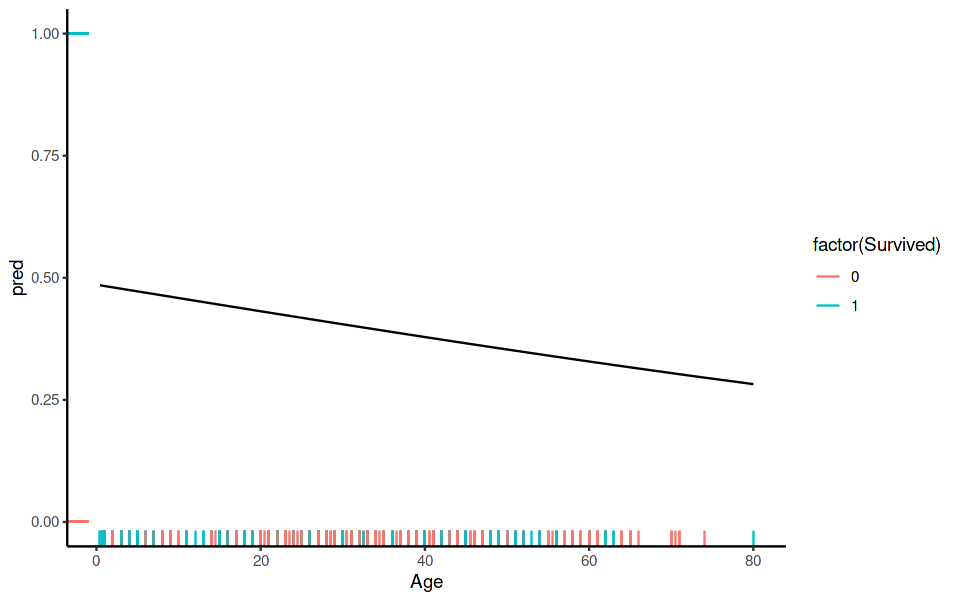

In [ ]:
titanic_df2 %>% add_predictions(mdl, type = "response")  %>% ggplot() + geom_line(aes(x = Age, y = pred)) +
    geom_rug(aes(x = Age, y = Survived, color = factor(Survived)))

### Logistic regression with multiple predictors

Just like with linear regression, multiple predictors can be added to logistic regression. The predicted log-odds becomes a multilinear function of the predictors:

$$\log \left( \frac{p}{1-p} \right) = a_0 + a_1 x_1 + \cdots + a_k x_k $$

In [ ]:
mdl <- glm(factor(Survived) ~ Class + Age + Sex, data = titanic_df, family = "binomial")
#                                                                   ^^^^^^ important! 
summary(mdl)


Call:
glm(formula = factor(Survived) ~ Class + Age + Sex, family = "binomial", 
    data = titanic_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0812  -0.7149  -0.6656   0.6858   2.1278  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   2.0438     0.1679  12.171  < 2e-16 ***
Class2nd     -1.0181     0.1960  -5.194 2.05e-07 ***
Class3rd     -1.7778     0.1716 -10.362  < 2e-16 ***
ClassCrew    -0.8577     0.1573  -5.451 5.00e-08 ***
AgeChild      1.0615     0.2440   4.350 1.36e-05 ***
SexMale      -2.4201     0.1404 -17.236  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2769.5  on 2200  degrees of freedom
Residual deviance: 2210.1  on 2195  degrees of freedom
AIC: 2222.1

Number of Fisher Scoring iterations: 4


The model we are fitting here is:

$$\underbrace{ \log\left( \frac{p_\text{survival}}{1-p_\text{survival}}  \right)}_\text{log odds ratio} = 2.04-1.02\times\texttt{\{2nd class\}}+\cdots-2.42\times \texttt{male}$$

To be clear, the "model" for how the above data was generated is the following:
1. First, I use all the predictors to form the log-odds ratio. For example, for an adult, male, third-class passenger, the predicted log-odds ratio is:

In [ ]:
titanic_df %>% add_predictions(mdl) %>% 
    filter(Class == "3rd", Sex == "Male", Age == "Adult") %>% head

Class,Sex,Age,Survived,pred
<chr>,<chr>,<chr>,<lgl>,<dbl>
3rd,Male,Adult,FALSE,-2.153985
3rd,Male,Adult,FALSE,-2.153985
3rd,Male,Adult,FALSE,-2.153985
3rd,Male,Adult,FALSE,-2.153985
3rd,Male,Adult,FALSE,-2.153985
3rd,Male,Adult,FALSE,-2.153985


2. The log-odds ratio is -2.153985. The predicted probability of survival is obtained by solving 

$$\log\left(\frac{p}{1-p}\right) = -2.153985$$ for $p$. 

To do this we apply the logistic function $f(x)=1/(1+e^{-x})$ to both sides:

$$p = \frac{1}{1 + \exp(2.153985)} = .104$$


3. Flip a coin that has $p=.104$ of coming up heads. If the coin is heads, the model predicts survival; if not, ...

## 🤔 Quiz

```
Call:
glm(formula = Survived ~ Class + Age + Sex, family = "binomial", 
    data = titanic_df)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   2.0438     0.1679  12.171  < 2e-16 ***
Class2nd     -1.0181     0.1960  -5.194 2.05e-07 ***
Class3rd     -1.7778     0.1716 -10.362  < 2e-16 ***
ClassCrew    -0.8577     0.1573  -5.451 5.00e-08 ***
AgeChild      1.0615     0.2440   4.350 1.36e-05 ***
SexMale      -2.4201     0.1404 -17.236  < 2e-16 ***
```

According to this model, what is the predicted probability that a first-class child female passenger survived?
<ol style="list-style-type: upper-alpha;">
    <li>60-70%</li>
    <li>70-80%</li>
    <li>80-90%</li>
    <li>&gt; 90%</li>
</ol>

In [ ]:
# first class child female

### ROC curve
With multiple predictors, we can no longer easily visualize the logistic regression model as we did above. However, there is a very useful visualization for assessing its performance as a classifier called the receiver operating characteric (ROC) curve. To understand what this represents, let's add the predicted probabilities to our model:

In [3]:
titanic_pred <- titanic_df %>% add_predictions(mdl, type = "response") %>% print

ERROR: ignored

The output of logistic regression is a set of _probabilities_ (numbers between 0 and 1), whereas the observed value is either 0 or 1. To convert from probabilities to prediction of 0 or 1, most of use would probably use the common sense rule

> Predict that Survived=1 if the predicted probability of survival is > 1/2.

In [ ]:
titanic_pred %>% mutate(Survived_hat = as.integer(pred > 1/2)) %>% head

Class,Sex,Age,Survived,pred,Survived_hat
<chr>,<chr>,<chr>,<lgl>,<dbl>,<int>
3rd,Male,Child,FALSE,0.2511586,0
3rd,Male,Child,FALSE,0.2511586,0
3rd,Male,Child,FALSE,0.2511586,0
3rd,Male,Child,FALSE,0.2511586,0
3rd,Male,Child,FALSE,0.2511586,0
3rd,Male,Child,FALSE,0.2511586,0


To evaluate our classifier we'll think about two measures:

- True positive rate: The percentage of people who are predicted to survive who in fact survived.
- False positive rate: The percentage of people who are predicted to perish who in fact perished.

In [ ]:
titanic_pred %>% mutate(
    Survived_hat = pred > .3,
    Perished = !Survived, 
    Perished_hat = !Survived_hat,
    tn = Perished_hat & Perished,  # true -
    tp = Survived & Survived_hat,  # true +
    fp = Survived_hat & Perished,  # false +
    fn = Perished_hat & Survived   # false -
) %>% summarize(
    fpr = sum(fp) / (sum(fp) + sum(tn)),  # fraction of true - incorrectly classified as +,
    tpr = sum(tp) / (sum(tp) + sum(fn))  # fraction of true + correctly classified as +
)

fpr,tpr
<dbl>,<dbl>
0.1637584,0.5864979


When we choose an extreme high value of the threshold, our classification rule always predicts `Survival = 0`, it has a false-positive rate of zero. This is good; we want our classifier to make as few false-positive predictions as possible. 

However, it also has a true positive rate of zero! So it has no power to correctly predict that any of the true survivors in fact survived.

Conversely, when we choose an extremely low value, it always predicts survival, so `TPR = FPR = 1`.

From the preceding discussion, we see that, given any probabilistic classifier, we can always make it have $\text{FPR}=\text{TPR}=1$ or $\text{FPR}=\text{TPR}=0$ by choosing an extreme probability cutoff. In other words, there is a tradeoff between having a good (i.e. close to zero) false-positive rate and a good (i.e. close to 1) true positive rate.

The ROC curve is a visual summary of this tradeoff. It plots the false positive rate on the $x$-axis, and the true positive rate on the $y$ axis. 

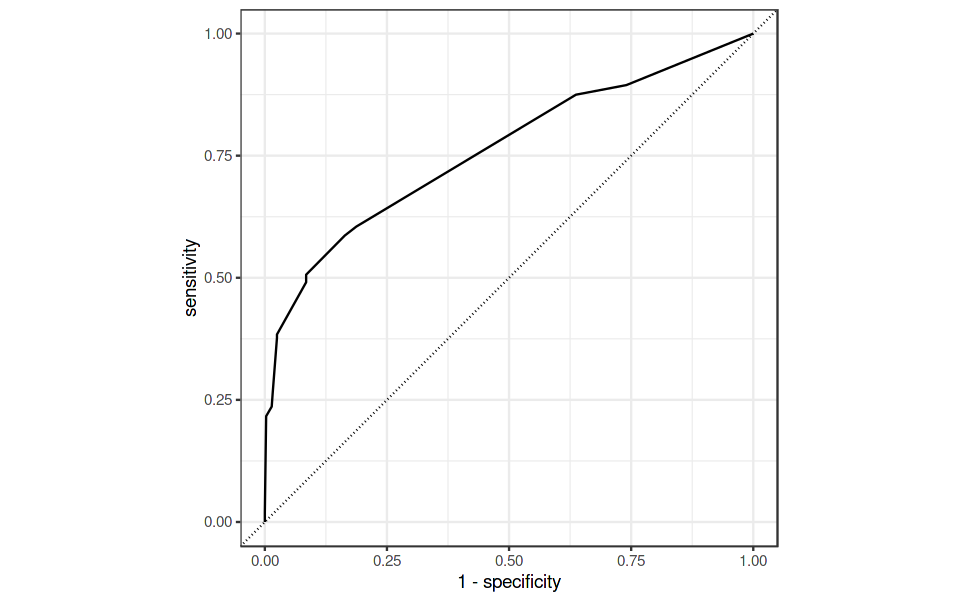

In [ ]:
roc <- titanic_pred %>% roc_curve(factor(!Survived), pred)
autoplot(roc)

The black curve plots the tradeoff between FPR and TPR as we vary the probability threshold of our classifier. The dotted line is $y=x$. The ROC curve should never dip below the dotted line (why?).

ROC curves can be useful for comparing two different classifiers. Let's try building a second model containing more terms:

In [ ]:
mdl2 <- glm(Survived ~ (Class + Age + Sex)^3, data = titanic_df, family = "binomial")
mdl2


Call:  glm(formula = Survived ~ (Class + Age + Sex)^3, family = "binomial", 
    data = titanic_df)

Coefficients:
               (Intercept)                    Class2nd  
                   3.55535                    -1.73827  
                  Class3rd                   ClassCrew  
                  -3.71325                    -1.65823  
                  AgeChild                     SexMale  
                  12.01072                    -4.28298  
         Class2nd:AgeChild           Class3rd:AgeChild  
                   1.73827                   -12.04697  
        ClassCrew:AgeChild            Class2nd:SexMale  
                        NA                     0.06801  
          Class3rd:SexMale           ClassCrew:SexMale  
                   2.79995                     1.13608  
          AgeChild:SexMale   Class2nd:AgeChild:SexMale  
                   4.28298                    -0.06801  
 Class3rd:AgeChild:SexMale  ClassCrew:AgeChild:SexMale  
                  -3.59619   

Intuition tells us that this larger model should do a better job of classifying survivorship. To check this, we can compare ROC curves for the two models:

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


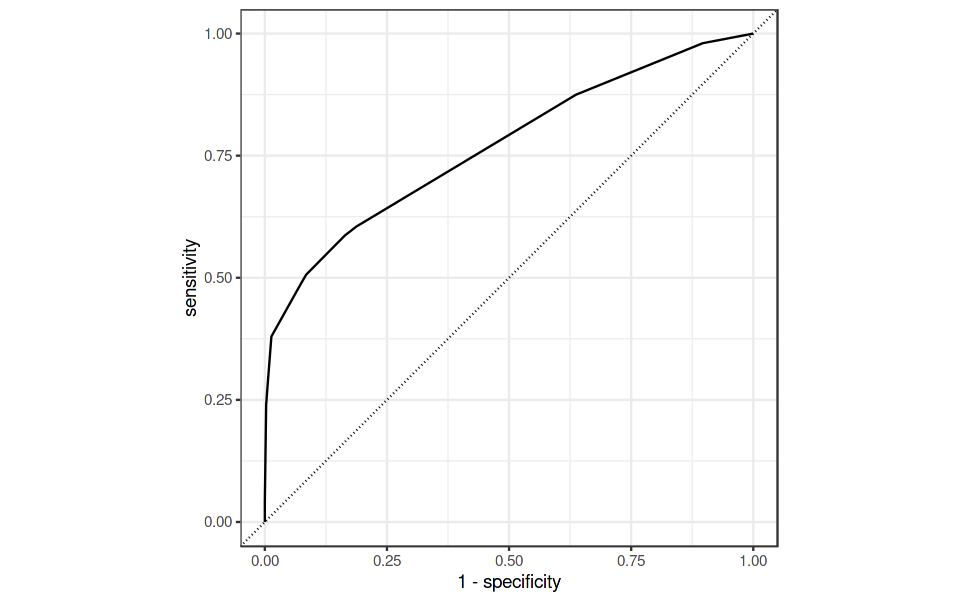

In [ ]:
roc2 <- titanic_df %>% add_predictions(mdl2) %>% roc_curve(factor(!Survived), pred)
autoplot(roc2)

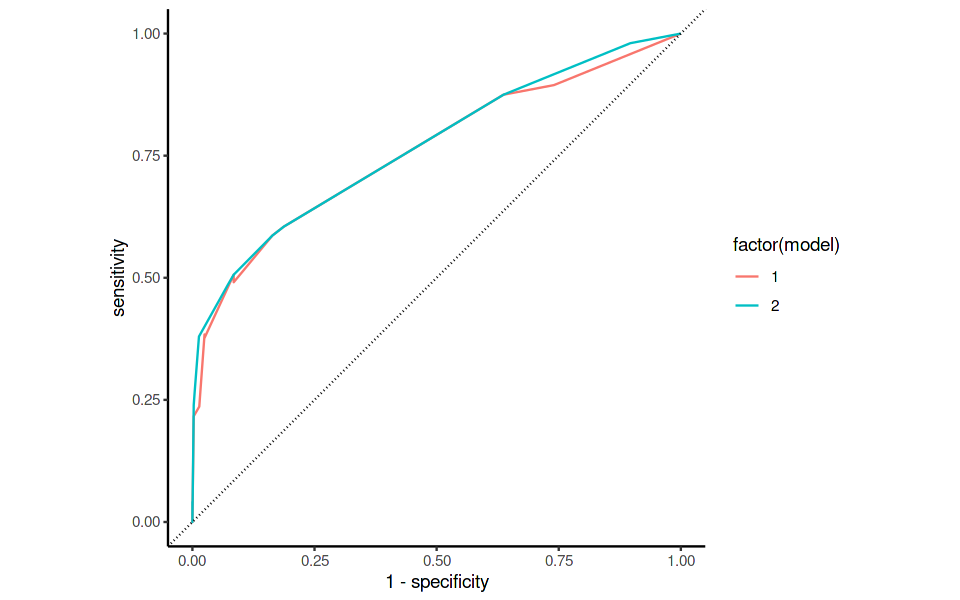

In [ ]:
bind_rows(mutate(roc, model=1), mutate(roc2, model=2)) %>% 
    ggplot(aes(x = 1 - specificity, y = sensitivity, color = factor(model))) + geom_line() +
    coord_equal() + geom_abline(linetype="dotted")

### Area under curve
A useful summary of the ROC curve is the area under the curve (AUC), which ranges between 1/2 and 1. A classifier that has AUC=1 can perfectly classify the data since it achieves TPR=1 and FPR=0.

In [ ]:
titanic_df %>% add_predictions(mdl) %>% roc_auc(factor(!Survived), pred)
titanic_df %>% add_predictions(mdl2) %>% roc_auc(factor(!Survived), pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.7597259


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.7684337


## Who will win?
![image.png](attachment:image.png)
Tonight is the final game of March Madness: UConn will play San Diego State for the national championship. Who will win the game? Given some data about each team, can we build a statistical model that predicts who will win?

In [ ]:
load(url('https://datasets.stats306.org/ncaa.RData'))

This command loads three tables:
- `ncaa_games`: outcomes of every game from 2002-2018.
- `ncaa_players`: all players and their stats for the same time period.
- `ncaa_schools`: table mapping schools to their numerical ID.

In [ ]:
ncaa_games %>% head

opponent_name,game_date,score,opponent_score,location,neutral_site_location,game_length,attendence,opponent_id,year,school_id
<chr>,<date>,<int>,<int>,<fct>,<chr>,<fct>,<int>,<int>,<int>,<int>
Sul Ross St.,2001-11-16,93,59,Home,NA,NA,2041,1390,2002,26172
Texas St.,2001-11-25,89,99,Home,NA,NA,1493,670,2002,26172
Loyola Chicago,2001-11-29,66,86,Away,NA,NA,1128,371,2002,26172
Illinois,2001-12-01,56,80,Away,NA,NA,16500,301,2002,26172
Texas,2001-12-05,64,89,Away,NA,NA,6099,703,2002,26172
UTEP,2001-12-08,56,82,Away,NA,NA,6203,704,2002,26172


In [ ]:
ncaa_schools %>% filter(school_id %in% c(1390, 26172))

school_id,school_name
<int>,<chr>
26172,A&M-Corpus Christi
1390,Sul Ross St.


In [ ]:
ncaa_players %>% head

player_name,class,season,position,height,g,fg_made,fg_attempts,fg_percent,3pt_made,⋯,steals_num,steals_avg,points_num,points_avg,turnovers,dd,td,player_id,year,school_id
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
"Brown, Jeremy",Fr.,2001-02,F,79,26,87,152,57.237,0,⋯,17,0.654,217,8.346,NA,NA,NA,110758,2002,2
"Coleman, Ryan",So.,2001-02,NA,NA,24,32,86,37.209,14,⋯,29,1.208,97,4.042,NA,NA,NA,61265,2002,2
"Johnson, Jeff",Fr.,2001-02,F,77,26,78,158,49.367,0,⋯,20,0.769,229,8.808,NA,NA,NA,162714,2002,2
"Johnson, Howard",So.,2001-02,NA,NA,24,80,222,36.036,43,⋯,34,1.417,232,9.667,NA,NA,NA,61260,2002,2
"Knight, Calvin",Fr.,2001-02,C,78,26,49,141,34.752,13,⋯,19,0.731,133,5.115,NA,NA,NA,162716,2002,2
"Lee, Rodney",Sr.,2001-02,G,75,26,119,301,39.535,64,⋯,28,1.077,353,13.577,NA,NA,NA,473441,2002,2


In [ ]:
ncaa_players[1,] %>% t

player_name,"Brown, Jeremy"
class,Fr.
season,2001-02
position,F
height,79
g,26
fg_made,87
fg_attempts,152
fg_percent,57.237
3pt_made,0
3pt_attempts,1


For this analysis, we will summarize each team by simply averaging the stats of each player on the team for that year:

In [ ]:
school_stats <- ncaa_players %>% 
    group_by(school_id, year) %>% 
    summarize(across(where(is.double), \(x) mean(x, na.rm = T))) %>% 
    select(-c(dd, td, turnovers))  # these are missing for almost every player/team

`summarise()` has grouped output by 'school_id'. You can override using the `.groups` argument.


Next, we need to create the data frame that we will use to train our model. This means joining data for each pair of teams that played in each game. Note that each game is represented twice in the dataset, with each team being called "opponent", e.g.:

In [ ]:
ncaa_games %>% filter(game_date == "2001-11-16", school_id == 26172 | opponent_id == 26172)

opponent_name,game_date,score,opponent_score,location,neutral_site_location,game_length,attendence,opponent_id,year,school_id
<chr>,<date>,<int>,<int>,<fct>,<chr>,<fct>,<int>,<int>,<int>,<int>
Sul Ross St.,2001-11-16,93,59,Home,NA,NA,2041,1390,2002,26172
A&M-Corpus Christi,2001-11-16,59,93,Away,NA,NA,2041,26172,2002,1390


Now we perform the join. (To make things go faster we are going to downsample the data to only 30,000 games.)

In [ ]:
ncaa_data <- ncaa_games %>% sample_n(30000) %>% inner_join(school_stats) %>% 
    inner_join(school_stats, join_by(opponent_id == school_id, year), suffix = c("", "_opponent")) %>% 
    mutate(win = score > opponent_score) 

Joining with `by = join_by(year, school_id)`


### Selecting a good model
Last lecture, we saw how to create large, rich regression models by including more and more predictors into our regression. But we also saw that this could actually decrease predictive accuracy when analyzing data that the model had never seen before. 

Now, we will learn ways to systematically find a good model by dividing our data and using out-of-sample predictive performance to guide model selection.

The first step will be to divide our data into two sets, training and test.
- We will use the **training** set to train our model, and then
- The **testing** set will be used to judge how accurate it is on new data.

In [ ]:
ncaa_split <- ncaa_data %>% 
    select(win, where(is.double), location, attendence, -game_date) %>% 
    filter(complete.cases(.)) %>% 
    initial_split(prop = .9)
training(ncaa_split) %>% glimpse
testing(ncaa_split) %>% glimpse

Rows: 24,925
Columns: 45
$ win                          <lgl> FALSE, FALSE, TRUE, FALSE, TRUE, FALSE, F…
$ height                       <dbl> 74.70588, 76.69231, 77.00000, 73.80000, 7…
$ g                            <dbl> 18.87500, 28.23077, 24.07692, 15.70000, 2…
$ fg_made                      <dbl> 40.81250, 72.07692, 62.00000, 27.65000, 4…
$ fg_attempts                  <dbl> 96.37500, 153.53846, 133.38462, 71.00000,…
$ fg_percent                   <dbl> 0.3857500, 0.4405385, 0.3886923, 2.532421…
$ `3pt_made`                   <dbl> 13.437500, 21.076923, 16.307692, 6.300000…
$ `3pt_attempts`               <dbl> 37.18750, 52.84615, 46.23077, 18.65000, 3…
$ `3pt_percent`                <dbl> 0.2818571, 0.2865455, 0.2271000, 1.802857…
$ freethrows_made              <dbl> 22.93750, 48.30769, 33.69231, 16.25000, 2…
$ freethrows_attempts          <dbl> 36.18750, 65.15385, 51.15385, 23.20000, 3…
$ freethrows_percent           <dbl> 0.7392308, 0.6266923, 0.6112500, 5.599437…
$ rebounds_num 

Let's try fitting the logistic regression model to this data set, and measure its performance using cross-entropy loss:

In [ ]:
mdl <- glm(win ~ (height + g + fg_made + rebounds_avg + height_opponent + fg_made_opponent)^2,
                  data = training(ncaa_split), family = "binomial")

In [ ]:
summary(mdl)


Call:
glm(formula = win ~ (height + g + fg_made + rebounds_avg + height_opponent + 
    fg_made_opponent)^2, family = "binomial", data = training(ncaa_split))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3595  -1.0956   0.5353   1.0786   4.8240  

Coefficients:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      -5.193e+01  2.790e+01  -1.861  0.06274 .  
height                            5.987e-01  3.970e-01   1.508  0.13156    
g                                -1.553e-01  3.922e-01  -0.396  0.69220    
fg_made                           1.356e-01  1.372e-01   0.989  0.32289    
rebounds_avg                     -1.050e-01  2.593e+00  -0.040  0.96770    
height_opponent                   7.041e-01  3.898e-01   1.806  0.07087 .  
fg_made_opponent                  1.117e-01  7.923e-02   1.409  0.15874    
height:g                         -2.144e-04  4.752e-03  -0.045  0.96402    
height:fg_made             

### Cross-entropy loss

Now let's define what it means for a binary prediction to be good. For a binary variable $y \in \{0, 1\}$ with predicted value $\hat{y} \in [0, 1]$, the *cross-entropy loss* is defined as 

$$ -y \log(\hat{y}) - (1 - y) \log(1 - \hat{y}) $$

(lower is better)

In [ ]:
cross.entropy <- function(y, yhat) {
    -y * log(yhat) - (1 - y) * log1p(-yhat)
}

In [ ]:
training(ncaa_split) %>% add_predictions(mdl, type = "response") %>% 
    mutate(loss = cross.entropy(win, pred)) %>% summarize(mean(loss, na.rm = T))

"mean(loss, na.rm = T)"
<dbl>
0.6410477


## Automatic model selection
Next, we will use the `tidymodels` packing to automate the process of finding a good model. First, we tell tidymodels that we want to perform logistic regression:

In [ ]:
lr_mod <- 
  logistic_reg(penalty = tune(), mixture = 1) %>% 
  set_engine("glmnet")

Next, we create a "recipe" that tells tidymodels how to set up the data for our prediction problem.

In [ ]:
lr_recipe <- recipe(win ~ ., data = ncaa_split) %>% 
    step_bin2factor(win) %>% 
    step_dummy(location)

In [ ]:
lr_workflow <- 
  workflow() %>% 
  add_model(lr_mod) %>% 
  add_recipe(lr_recipe)

In [ ]:
val_set <- validation_split(training(ncaa_split))
lr_reg_grid <- tibble(penalty = 10^seq(-4, -1, length.out = 30))
lr_res <- 
  lr_workflow %>% 
  tune_grid(val_set,
            grid = lr_reg_grid,
            control = control_grid(save_pred = TRUE),
            metrics = metric_set(roc_auc))

In [ ]:
lr_res

In [ ]:
## A different algorithm

In [ ]:
rf_mod <- 
  rand_forest(mtry = tune(), min_n = tune(), trees = 1000) %>% 
  set_engine("ranger", num.threads = cores) %>% 
  set_mode("classification")